In [300]:
import numpy as np
import sys,os
from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
from matplotlib.ticker import FormatStrFormatter

sys.path.append("..")
import pyrads

from scipy.integrate import trapz,simps,cumtrapz


In [282]:
S = 1361.5
albedo = 0.30
ISR = ((1-albedo)*S)/4.

In [283]:
data = np.load("output/olr_dense.npz")

In [284]:
olr_spec = data["olr_spec"]
CO2_vec = data["CO2_vec"]
Ts_vec = data["Ts_vec"]
Tstrat = data["Tstrat"]
n = data["n"]
B_strat = data["B_strat"]
B_surf = data["B_surf"]
RH = data["RH"]

In [285]:
def smooth_func_n(func,n,smoothing = 100):
    func_smooth = np.array([np.average(func[i*smoothing:(i+1)*smoothing])
                                for i in range(len(n)//smoothing)])
    n_smooth = np.array([np.average(n[i*smoothing:(i+1)*smoothing]) for i in range(len(n)//smoothing)])
    return func_smooth, n_smooth

In [286]:
nframes = 500
iterations_CO2 = np.logspace(-6,np.log10(5.e-3),nframes-1)

Slowly increasing CO2 levels:
1.0


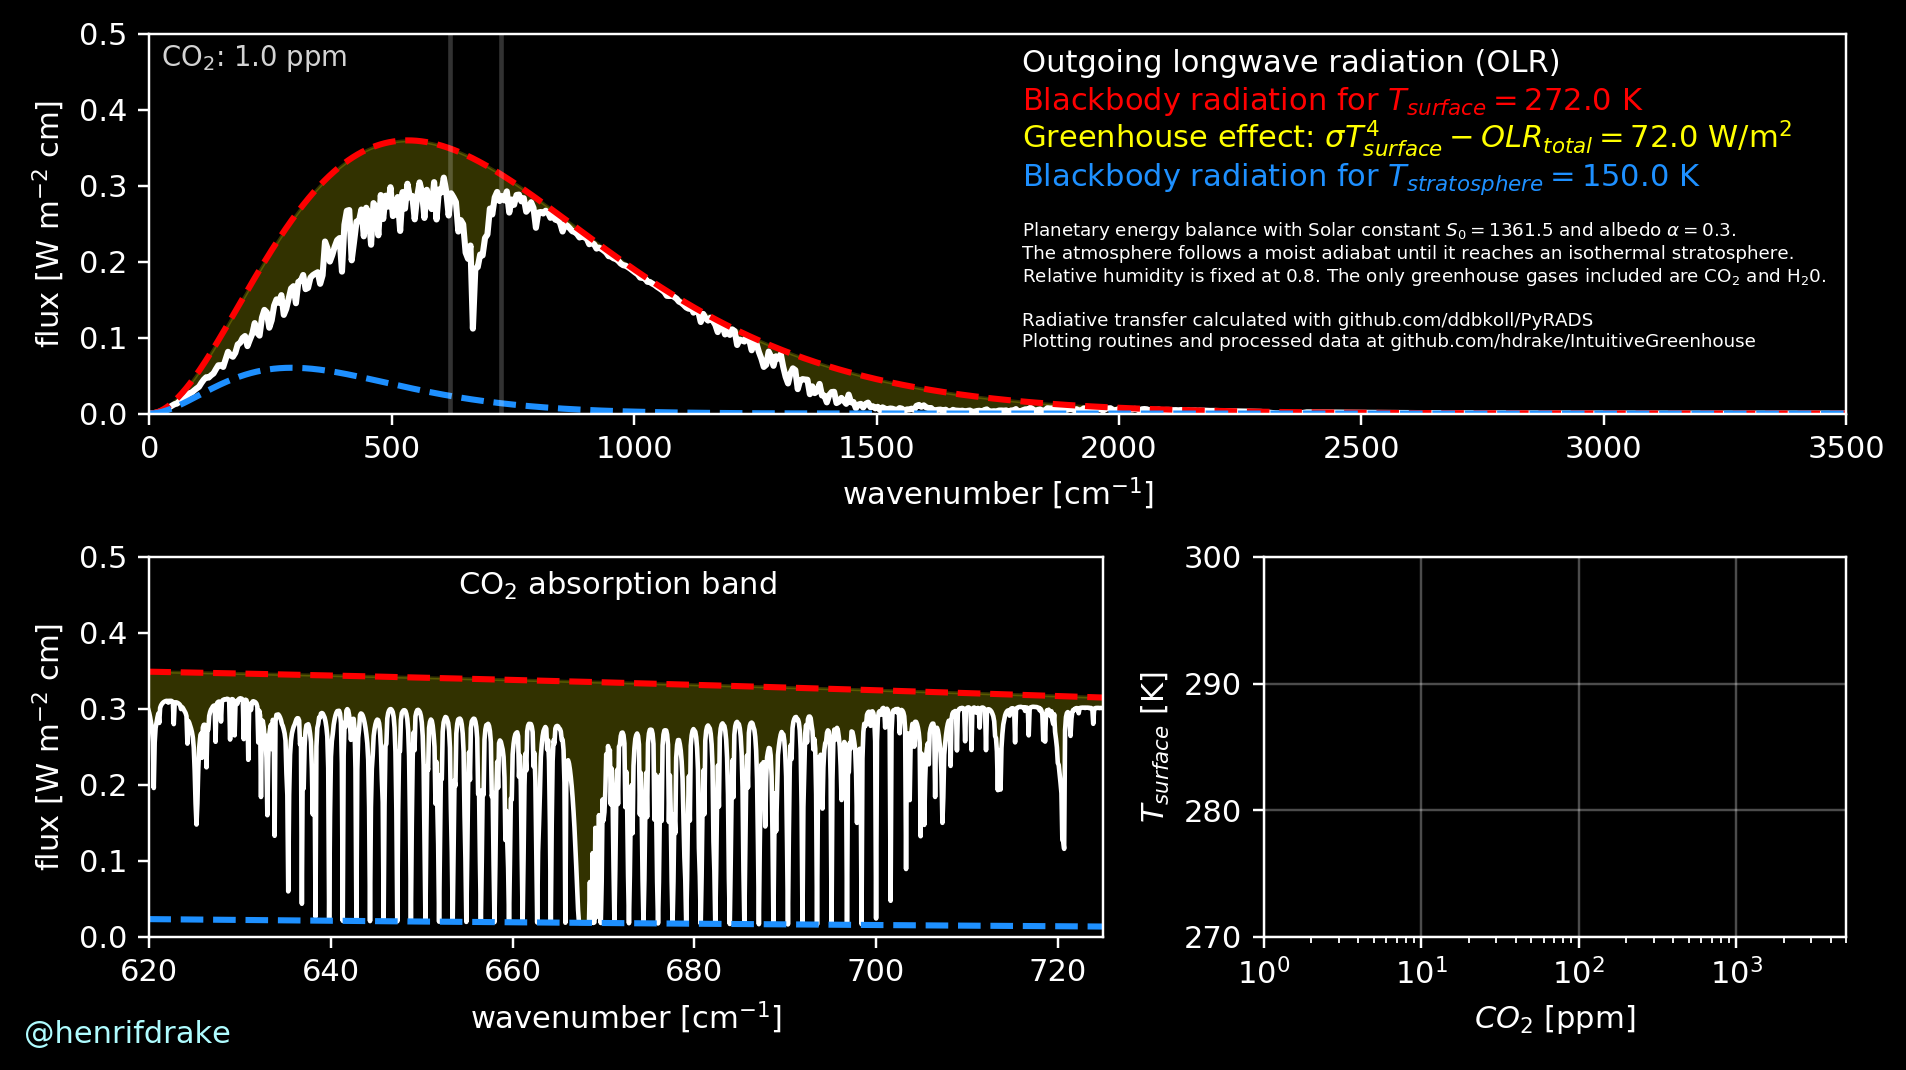

In [299]:
my_dpi=220.
plt.figure(figsize=(1920./my_dpi,1080./my_dpi),dpi=my_dpi)

frame_count = 0
fadeout = 1.0
fadein = 0.0

Ts_acc = np.array([])
CO2_acc = np.array([])
print('Slowly increasing CO2 levels:')
for CO2 in iterations_CO2:
    if not(frame_count%100): print(CO2*1.e6)
    CO2_acc = np.append(CO2_acc,CO2)
    
    CO2_idx = np.sort(np.argsort(np.abs(CO2_vec-CO2))[0:3])

    itp_olr_spec_CO2 = interpolate.interp1d(CO2_vec[CO2_idx],olr_spec[CO2_idx,:,:],axis=0)
    itp_olr_B_strat = interpolate.interp1d(CO2_vec[CO2_idx],B_strat[CO2_idx,:,:],axis=0)
    itp_olr_B_surf = interpolate.interp1d(CO2_vec[CO2_idx],B_surf[CO2_idx,:,:],axis=0)

    olr_spec_interp = itp_olr_spec_CO2(CO2)
    B_strat_interp = itp_olr_B_strat(CO2)
    B_surf_interp = itp_olr_B_surf(CO2)
    olr_interp = simps(olr_spec_interp,n,axis=1)

    olr_idx = np.sort(np.argsort(np.abs(olr_interp-ISR))[0:3])

    itp_olr = interpolate.interp1d(olr_interp[olr_idx],olr_spec_interp[olr_idx,:],axis=0)
    itp_B_strat = interpolate.interp1d(olr_interp[olr_idx],B_strat_interp[olr_idx,:],axis=0)
    itp_B_surf = interpolate.interp1d(olr_interp[olr_idx],B_surf_interp[olr_idx,:],axis=0)
    itp_Ts = interpolate.interp1d(olr_interp[olr_idx],Ts_vec[olr_idx],axis=0)

    olr_balanced = itp_olr(ISR)
    B_strat_balanced = itp_B_strat(ISR)
    B_surf_balanced = itp_B_surf(ISR)
    Ts_balanced = itp_Ts(ISR)
    Ts_acc = np.append(Ts_acc,Ts_balanced)
    
    GH_effect = simps(B_surf_balanced-olr_balanced,n)

    olr_balanced_smooth, n_smooth = smooth_func_n(olr_balanced,n,50)
    B_surf_balanced_smooth, n_smooth = smooth_func_n(B_surf_balanced,n,50)

    plt.subplot2grid((2, 10), (0, 0), colspan=10)
    plt.fill_between(n_smooth,olr_balanced_smooth,B_surf_balanced_smooth,color='yellow',alpha=0.2)
    plt.plot(n_smooth,olr_balanced_smooth,'-',color='white',lw=2)
    plt.plot(n,B_surf_balanced,linestyle='--',color='red',lw=2)
    plt.plot(n,B_strat_balanced,linestyle='--',color='dodgerblue',lw=2)
    plt.xlim([0,3500])
    plt.ylim([0,0.5])
    plt.xlabel(r'wavenumber [cm$^{-1}$]')
    plt.ylabel(r'flux [W m$^{-2}$ cm]')
    plt.plot([620.,620.],[0.,0.5],'-',color='white',alpha=0.2)
    plt.plot([725.,725.],[0.,0.5],'-',color='white',alpha=0.2)

    plt.annotate(s=r"CO$_{{2}}$: ${0}$ ppm".format(round(CO2*1.e6,2)),
                 color='lightgray', fontsize = 9., xy=(25.,0.4575))
    plt.annotate(s=r"Outgoing longwave radiation (OLR)",
                 color='white',xy=(1800.,0.45))
    plt.annotate(s=r"Blackbody radiation for $T_{{surface}} = {0}$ K".format(round(Ts_balanced,1)),
                 color='red',xy=(1800.,0.4))
    plt.annotate(s=r"Greenhouse effect: $\sigma T_{{surface}}^{{4}} - OLR_{{total}}  = {0}$ W/m$^{{2}}$".format(round(GH_effect)),
                 color='yellow',xy=(1800.,0.35))
    plt.annotate(s=r"Blackbody radiation for $T_{{stratosphere}} = {0}$ K".format(round(Tstrat)),
                 color='dodgerblue',xy=(1800.,0.30))

    caption = (r"Planetary energy balance with Solar constant $S_{0}=1361.5$ and albedo $\alpha = 0.3$."
               "\n"
               r"The atmosphere follows a moist adiabat until it reaches an isothermal stratosphere."
               "\n"
               r"Relative humidity is fixed at 0.8. The only greenhouse gases included are CO$_{2}$ and H$_{2}$0."
               "\n\nRadiative transfer calculated with github.com/ddbkoll/PyRADS"
               "\nPlotting routines and processed data at github.com/hdrake/IntuitiveGreenhouse"
              )
    
    final_caption = ("Note that the only major feedback this calculation includes is water vapor.\n\n"
                     "The evidence from more comprehensive climate models and past climates is that\n"
                     r"Earth will warm by 2$^{\circ}$C to 4.5$^{\circ}$C every time CO$_{2}$ double."
                     "\n\n"
                     r"Since the 1800s, humans have already increased CO$_{2}$ concentrations by roughly 45%"
                     "\n"
                     r"and global temperatures have risen by roughly 1$^{\circ}$C (or 1.8$^{\circ}$F)."
                    )
    
    if frame_count<100:
        if frame_count>20:
            fadeout = max(0.,fadeout-0.0125)
        plt.text(1800,0.09,caption,fontsize=6.0,alpha=fadeout)
    elif frame_count>nframes-20:
        fadein = min(1.0,fadein+0.05)
        plt.text(1800,0.065,final_caption,fontsize=6.5,alpha=fadein)

    plt.subplot2grid((2, 10), (1, 0), colspan=6)
    plt.fill_between(n,olr_balanced,B_surf_balanced,color='yellow',alpha=0.2)
    plt.plot(n,olr_balanced,'-',color='white',lw=1.5)
    plt.plot(n,B_surf_balanced,linestyle='--',color='red',lw=2)
    plt.plot(n,B_strat_balanced,linestyle='--',color='dodgerblue',lw=2)
    plt.xlim([620,725])
    plt.ylim([0,0.5])
    plt.xlabel(r'wavenumber [cm$^{-1}$]')
    plt.ylabel(r'flux [W m$^{-2}$ cm]')

    ax = plt.subplot2grid((2, 10), (1, 6), colspan=4)
    plt.semilogx(CO2_acc*1.e6,Ts_acc,'-',color='red',lw=2)
    plt.yticks(np.arange(270.,310.,10.),np.arange(270.,310.,10.))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.ylabel(r'$T_{surface}$ [K]')
    plt.xlabel(r'$CO_{2}$ [ppm]')
    plt.ylim([270.,300.])
    plt.xlim([1.e0,5.e3])
    plt.grid(True,alpha=0.3)

    plt.tight_layout()

    arrowprops = dict(arrowstyle="-",alpha=0.2)
    plt.annotate(r'CO$_{2}$ absorption band',xy=(0.24,0.445),xycoords='figure fraction',color='white')

    
    plt.annotate('@henrifdrake',xy=(0.0125,0.025),xycoords='figure fraction',fontsize=10,fontweight='roman',color=(175./255.,252./255.,255./255.))

    plt.savefig('figures/{0}.png'.format(np.str(frame_count).zfill(4)))
    #plt.clf()
    
    frame_count+=1
    break